α_D central train point: ('1.1000', '2.7500')
[210 211 195 212 196 180 197 181 213 165 182 198 166 214 150 183 167 199
 151 215 135 168 184 200 152 216 136 120 169 185 153 201 137 217 121 105
 170 186 154 202 138 218 122 106 171 155 187 139 203  90 219 123 107 172
 156 188  91 140 204 220 124 108  75 173 189 157  92 205 141 221 125 109
  76 174 190 206 158 222  93 142 126  60 110  77 191 207 175 223 159 143
  94 127  61 111 208 224 192  78 176 160 144  95 128 209 193  62  45 177
 112  79 161 145  96 129 194 178 162  63 113  46  80 146  97 130 179 163
 114 147  64  47  81 131  98 164  30 148 115  65  82 132  48  99 149 116
  31 133  66  83 100  49 117 134  32  84  67 101 118  50  15  33  85 102
  68 119  51 103  86  69  34  16  52 104  87  70  35  17  53  88  71  36
  54  18  89  72  37   0  55  19  73  38  56   1  20  74  39  57   2  21
  58  40  22   3  59  41  23   4  42  24   5  43  25   6  44  26   7  27
   8  28   9  29  10  11  12  13  14]
839.1048845448784 904.9703037081866 65.8

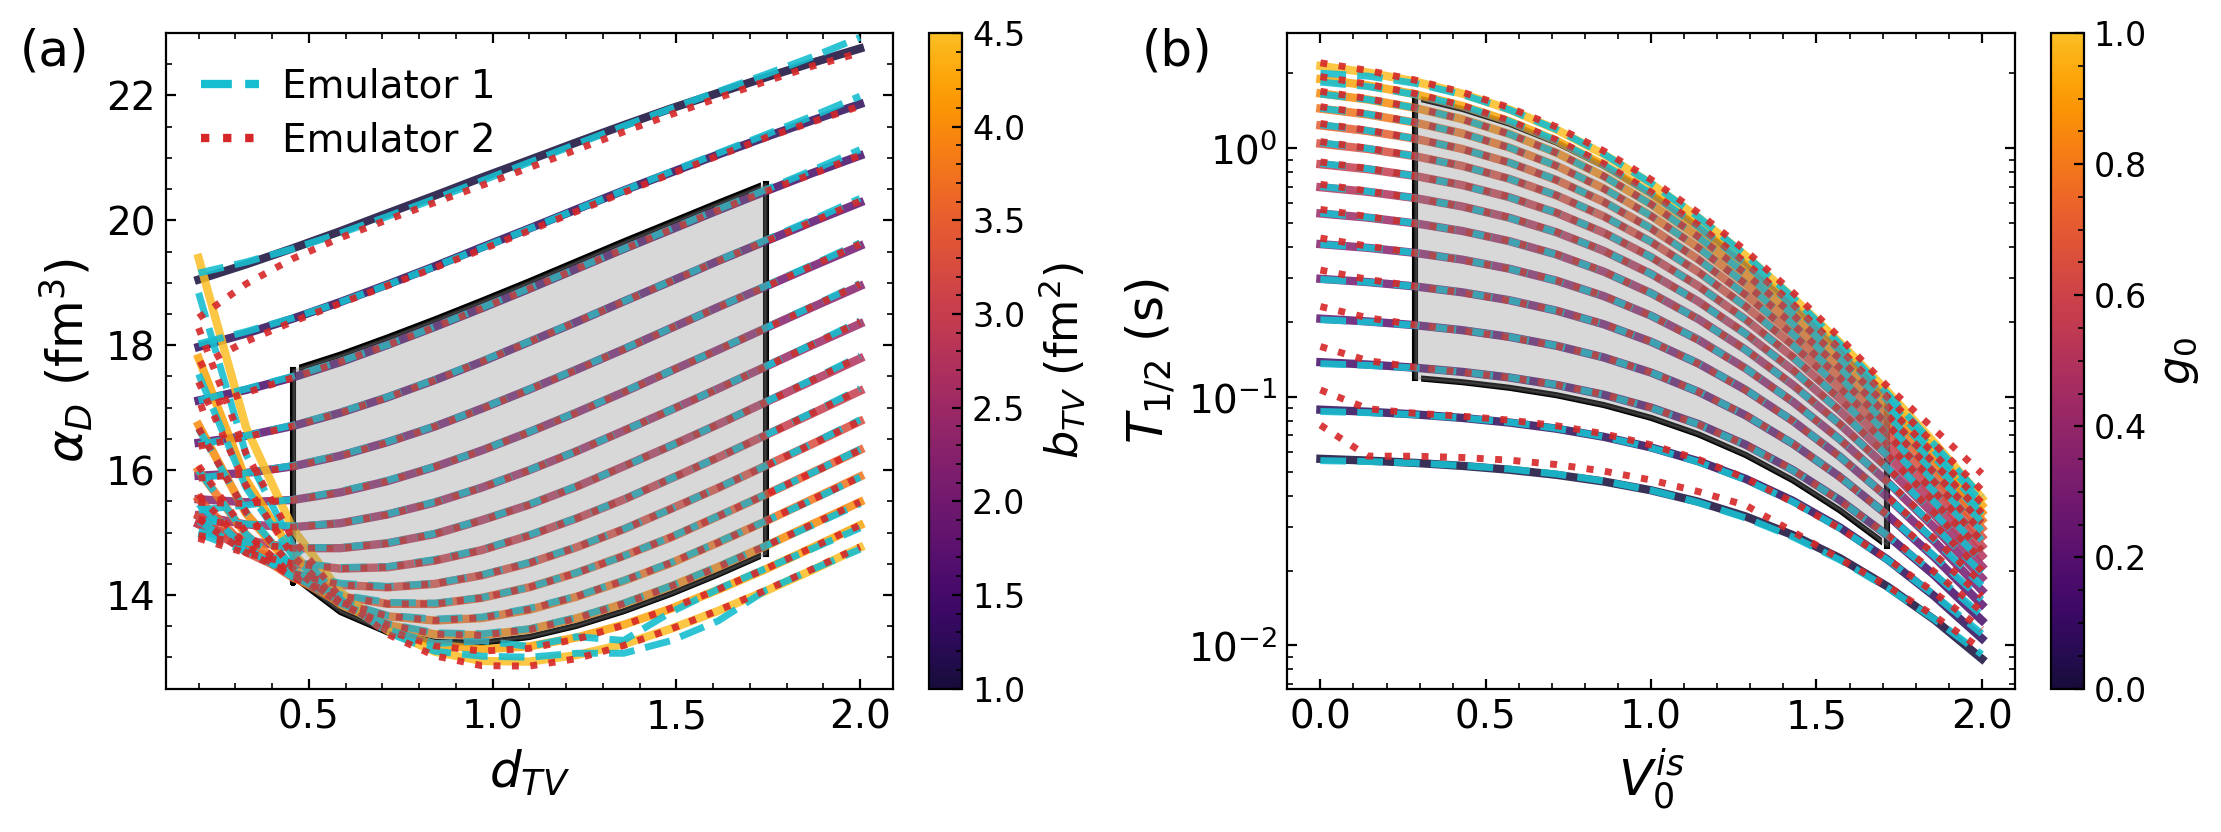

In [18]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

from __future__ import annotations
import os, re, sys
from pathlib import Path
import pandas as pd
from matplotlib.colors import Colormap
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
import matplotlib.cm as cm  
import matplotlib.colors as mcolors
import matplotlib.patheffects as pe

# --- Imports from your project layout ---
# add project root (parent of figs/) to import path if needed
sys.path.insert(0, str(Path("..").resolve()))
from Beta_decay import helper as beta_helper
from dipoles_exp_param import helper as dipole_helper
from numpy.polynomial.polynomial import Polynomial
import tensorflow as tf


############ Some extra handles for Pablo's modifications ############

EVERY=1   # Plot every # curves, to make the plot less bussy if desired 
LINEWIDTH=3   #line width of the HF solutions

# Emu1_color= "#1f77b4" # Vivid blue
Emu1_color= "#17becf" # Cyan
Emu2_color=    "#d62728" # Strong red
Emu_linethick=2.5
DY = 0.12          # lift top by +DY and bottom by -DY (α_D is linear)
FAC = 1.1

FILL_ALPHA = 0.3  # transparency of the gray fill

####################################################################################


def truncate_colormap(cmap, min_val=0.0, max_val=0.5, n=256):
    """Return a copy of `cmap` clipped to [min_val, max_val] in its color range."""
    return mcolors.LinearSegmentedColormap.from_list(
        f"trunc({cmap.name},{min_val:.2f},{max_val:.2f})",
        cmap(np.linspace(min_val, max_val, n))
    )


inferno_trunc = truncate_colormap(cm.inferno, min_val=0.1, max_val=0.85)


# name = "inferno_trunc_02_30"   # NEW unique name
# try:
#     plt.colormaps.register(inferno_trunc, name=name)
# except ValueError:
#     pass

# ---------------- rcParams (global styling) ----------------
plt.rcParams.update({
    "figure.dpi": 200,
    "savefig.dpi": 200,
    "xtick.direction": "in",
    "ytick.direction": "in",
    "xtick.top": True,
    "ytick.right": True,
    "xtick.minor.visible": True,
    "ytick.minor.visible": True,
    "xtick.labelsize": 14,
    "ytick.labelsize": 14,
    'axes.labelsize':14
})

# ====================== Utilities ======================

def parse_pairs_from_dir(directory: str | Path, regex: str, order=("alpha","beta")) -> list[tuple[float,float]]:
    """
    Scan directory, extract (alpha, beta) from filenames using a regex with two groups.
    `order` tells which group is alpha vs beta in the filename.
    """
    pat = re.compile(regex)
    pairs = []
    for fname in os.listdir(directory):
        m = pat.match(fname)
        if not m:
            continue
        g1, g2 = m.group(1), m.group(2)
        a, b = (float(g1), float(g2)) if order == ("alpha","beta") else (float(g2), float(g1))
        pairs.append((a, b))
    return pairs

def read_train_set_centroid(train_set_txt: str | Path) -> tuple[str,str]:
    """Return the *string* tuple of the training point closest to centroid (to match your helpers)."""
    pts = []
    with open(train_set_txt, "r") as f:
        for line in f:
            pts.append(tuple(map(str, line.strip().split(","))))
    arr = np.array(pts, dtype=float)
    centroid = arr.mean(axis=0)
    idx = np.argmin(np.linalg.norm(arr - centroid, axis=1))
    return pts[idx]

def to_emulator_array(points: list[tuple[float,float]], values: np.ndarray) -> np.ndarray:
    """Pack (alpha, beta, value) rows for plotting."""
    ab = np.array(points, float)
    z = np.asarray(values, float).reshape(-1, 1)
    return np.concatenate([ab[:, [0]], ab[:, [1]], z], axis=1)

def plot_family_by_constant_x(ax, table3: np.ndarray, cmap_name="inferno_trunc_02_30", x_label="", y_label="", cbar_label="", every=1):
    """
    Plot families of true curves for unique x (col 0), y is col 1, z is col 2.
    Returns (norm, sm, unique_x) so you can reuse the colorbar and uniques.
    """
    xvals = table3[:, 0]
    uniq_all = np.unique(xvals)
    uniq = uniq_all[::every]                   # ← plot every Nth family
    # uniq = np.unique(xvals)
   

    # cmap = plt.get_cmap(cmap_name)
    cmap = cmap_name if isinstance(cmap_name, Colormap) else plt.get_cmap(cmap_name)

    
    norm = Normalize(vmin=float(xvals.min()), vmax=float(xvals.max()))
    
    for xv in uniq:
        data = table3[table3[:, 0] == xv]
        data = data[data[:, 1].argsort()]
        ax.plot(data[:, 1], data[:, 2],
                color=cmap(norm(xv)), lw=LINEWIDTH, alpha=0.85)
    
    sm = ScalarMappable(cmap=cmap, norm=norm)
    
    # cmap = plt.get_cmap(cmap_name)
    
    # colors = [cmap(i / (len(uniq) - 1 if len(uniq) > 1 else 1)) for i in range(len(uniq))]

    # for i, xv in enumerate(uniq):
    #     data = table3[table3[:, 0] == xv]
    #     data = data[data[:, 1].argsort()]
    #     ax.plot(data[:, 1], data[:, 2], color=colors[i], lw=LINEWIDTH, alpha=0.85)

    # norm = Normalize(vmin=float(np.min(xvals)), vmax=float(np.max(xvals)))
    # sm = ScalarMappable(cmap=cmap_name, norm=norm)
    sm = ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, label=cbar_label)
    cbar.ax.tick_params(labelsize=12)
    cbar.set_label(cbar_label, fontsize=16)

    ax.set_xlabel(x_label, fontsize=18)
    ax.set_ylabel(y_label, fontsize=18)
    return norm, sm, uniq

def plot_family_by_constant_y(ax, table3: np.ndarray, cmap_name="inferno_trunc_02_30", x_label="", y_label="", cbar_label="", every=1):
    """
    Plot families grouped by constant y (col 1), x is col 0, z is col 2.
    Colorbar encodes unique y values.
    """
    yvals = table3[:, 1]
    # uniq = np.unique(yvals)
    uniq_all = np.unique(yvals)
    uniq = uniq_all[::every]                   # ← plot every Nth family


    # cmap = plt.get_cmap(cmap_name)
    cmap = cmap_name if isinstance(cmap_name, Colormap) else plt.get_cmap(cmap_name)
    norm = Normalize(vmin=float(yvals.min()), vmax=float(yvals.max()))
    
    for yv in uniq:
        data = table3[table3[:, 1] == yv]
        data = data[data[:, 0].argsort()]
        ax.plot(data[:, 0], data[:, 2],
                color=cmap(norm(yv)), lw=LINEWIDTH, alpha=0.85)
    
    sm = ScalarMappable(cmap=cmap, norm=norm)
    # cmap = plt.get_cmap(cmap_name)
    # colors = [cmap(i / (len(uniq) - 1 if len(uniq) > 1 else 1)) for i in range(len(uniq))]

    # for i, yv in enumerate(uniq):
    #     data = table3[table3[:, 1] == yv]
    #     data = data[data[:, 0].argsort()]   # sweep over x (col 0)
    #     ax.plot(data[:, 0], data[:, 2], color=colors[i], lw=LINEWIDTH, alpha=0.85)

    # norm = Normalize(vmin=float(np.min(yvals)), vmax=float(np.max(yvals)))
    # sm = ScalarMappable(cmap=cmap_name, norm=norm)
    sm = ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, label=cbar_label)
    cbar.ax.tick_params(labelsize=12)
    cbar.set_label(cbar_label, fontsize=16)

    ax.set_xlabel(x_label, fontsize=18)
    ax.set_ylabel(y_label, fontsize=18)
    return norm, sm, uniq


def overlay_emulator_lines(ax, emu: np.ndarray, group_by="y", color="k", ls="--", label=None, every=1):
    """
    Overlay emulator lines grouped by constant x or y.
    emu: (alpha, beta, value)
    """
    col = 1 if group_by == "y" else 0
    x_axis = 0 if group_by == "y" else 1  # when group_by=y, x-axis is alpha (col 0), else beta
    uniq = np.unique(emu[:, col])[::every]     # ← subsample
    # uniq = np.unique(emu[:, col])
    for u in uniq:
        data = emu[emu[:, col] == u]
        data = data[data[:, x_axis].argsort()]
        ax.plot(data[:, x_axis], data[:, 2], color=color, ls=ls,  alpha = 0.9,linewidth =Emu_linethick)
    if label:
        ax.plot([], [], color=color, ls=ls, label=label)

# ====================== α_D panel ======================

def make_alphaD_panel(ax):
    # --- parse (alpha, beta) from filenames (strength: strength_(beta)_(alpha).out) ---
    strength_dir = Path("../dipoles_data_all/total_strength")
    # filename groups: (beta, alpha) → order tells us which is alpha/beta in result
    pairs = parse_pairs_from_dir(strength_dir, r"^strength_([0-9.]+)_([0-9.]+)\.out$", order=("beta","alpha"))
    # convert to canonical (alpha,beta) ordering
    pairs = [(f"{a:.4f}", f"{b:.4f}") for (a, b) in pairs]

    # --- training centroid (as strings for your helper) ---
    central_point = read_train_set_centroid("../dipoles_exp_param/train_set.txt")
    print("α_D central train point:", central_point)

    # --- true data via your helper ---
    _, alphaD_list = dipole_helper.data_table(pairs)
    alphaD_true = np.vstack(alphaD_list)  # columns: alpha, beta, α_D

    # --- Emulator (simple) ---
    n_simple = 10
    p_simple = np.loadtxt(f"../dipoles_exp_param/params_{n_simple}_only_alphaD.txt").astype(np.float32)
    alphaD_opt, alphaD_orig, _ = dipole_helper.plot_alphaD_simple(pairs, p_simple, n_simple, central_point)
    emu_simple = to_emulator_array(pairs, alphaD_opt)

    # --- Emulator 1 ---
    n1, retain1 = 16, 0.6
    p1 = np.loadtxt(f"../dipoles_exp_param/params_{n1}_{retain1}.txt").astype(np.float32)
    alphaD_em1, _, _ = dipole_helper.plot_alphaD(pairs, p1, n1, central_point, retain1)
    emu1 = to_emulator_array(pairs, alphaD_em1)

    # --- plot: true families by constant alpha (x=alpha), x-axis is beta (col 1) ---
    plot_family_by_constant_x(
        ax,
        alphaD_true,
        cmap_name=inferno_trunc,
        x_label=r"$d_{TV}$",
        y_label=r"$\alpha_D$ (fm$^3$)",
        cbar_label=r"$b_{TV}$ (fm$^{2}$)",
        every=EVERY
    )
    # overlay emulators: group by constant beta (vary alpha on x-axis) or vice versa
    overlay_emulator_lines(ax, emu1, group_by="y", color=Emu1_color, ls="--", label="Emulator 1",every=EVERY)
    overlay_emulator_lines(ax, emu_simple, group_by="y", color=Emu2_color, ls=":", label="Emulator 2",every=EVERY)
    

    leg = ax.legend(
    frameon=False,
    fontsize=14,        
    handlelength=1.5,
    # handlewidth=2,
    handletextpad=0.6,
    labelspacing=0.4,
)

    
    ######################################################################
    # training rectangle limits (d_TV, b_TV)

    train_pts = []
    with open("../dipoles_exp_param/train_set.txt", "r") as f:
        for line in f:
            a, b = line.strip().split(",")
            train_pts.append((float(a), float(b)))
    d_min, d_max = np.min([p[0] for p in train_pts]), np.max([p[0] for p in train_pts])
    b_min, b_max = np.min([p[1] for p in train_pts]), np.max([p[1] for p in train_pts])
    
    # alphaD_true columns: [b_TV, d_TV, α_D]
    Btv = alphaD_true[:, 0]
    Dtv = alphaD_true[:, 1]
    Y   = alphaD_true[:, 2]
    
    def _half_step(u):
        u = np.unique(np.sort(u)); d = np.diff(u); d = d[d > 0]
        return 0.5 * (d.min() if d.size else 1e-6)
    
    tol_b = _half_step(Btv)
    tol_d = _half_step(Dtv)
    
    # edges at constant bTV
    bot = alphaD_true[(np.abs(Btv - b_min) <= tol_b) & (Dtv >= d_min - 1e-12) & (Dtv <= d_max + 1e-12)]
    top = alphaD_true[(np.abs(Btv - b_max) <= tol_b) & (Dtv >= d_min - 1e-12) & (Dtv <= d_max + 1e-12)]
    bot = bot[np.argsort(bot[:, 1])]   # sort by d_TV
    top = top[np.argsort(top[:, 1])]
    
    # Decide which one is the *upper* edge in α_D
    upper_arr, lower_arr = top, bot
    b_lower, b_upper = b_min, b_max
    if np.nanmedian(top[:, 2]) < np.nanmedian(bot[:, 2]):
        upper_arr, lower_arr = bot, top
        b_lower, b_upper = b_max, b_min  # swap because "bottom" is at b_max
    
    # Apply vertical padding
    x_lower, y_lower = lower_arr[:, 1], lower_arr[:, 2] - DY
    x_upper, y_upper = upper_arr[:, 1], upper_arr[:, 2] + DY
    
    # Fill interior
    ax.fill_between(x_lower, y_lower, y_upper, color='0.5', alpha=FILL_ALPHA, zorder=180)
    
    # Sides at fixed dTV
    lef = alphaD_true[(np.abs(Dtv - d_min) <= tol_d) & (Btv >= b_min - 1e-12) & (Btv <= b_max + 1e-12)]
    rig = alphaD_true[(np.abs(Dtv - d_max) <= tol_d) & (Btv >= b_min - 1e-12) & (Btv <= b_max + 1e-12)]
    lef = lef[np.argsort(lef[:, 0])]  # by b_TV
    rig = rig[np.argsort(rig[:, 0])]
    
    # Offset the sides smoothly from -DY at b_lower to +DY at b_upper
    pefx = [pe.Stroke(linewidth=4.0, foreground="white"), pe.Normal()]
    kw   = dict(color="k", lw=2.2, zorder=1, path_effects=pefx)
    
    ax.plot(x_lower, y_lower, **kw)   # lower edge
    ax.plot(x_upper, y_upper, **kw)   # upper edge
    
    if lef.size:
        frac_lef = (lef[:, 0] - b_lower) / (b_upper - b_lower + 1e-12)
        y_lef = lef[:, 2] + (-DY + 2*DY*frac_lef)
        ax.plot(lef[:, 1], y_lef, **kw)   # x is d_TV
    
    if rig.size:
        frac_rig = (rig[:, 0] - b_lower) / (b_upper - b_lower + 1e-12)
        y_rig = rig[:, 2] + (-DY + 2*DY*frac_rig)
        ax.plot(rig[:, 1], y_rig, **kw)

    ######################################################################

    for line in leg.get_lines():
        line.set_linewidth(3.0)

    
    ax.set_ylim(12.5, 23)


# ====================== Half-life panel ======================

def make_half_life_panel(ax):
    A, Z, g_A, nucnam = 80, 28, 1.2, "Ni_80"

    # phase-space polynomial
    poly = beta_helper.fit_phase_space(0, Z, A, 15)
    coeffs = Polynomial(poly).coef
    # (optional demo evaluation)
    # x_values = np.linspace(0.611, 15, 100)
    # _ = beta_helper.evaluate_polynomial_tf(tf.constant(coeffs[::-1], tf.float64),
    #                                        tf.constant(x_values, tf.float64)).numpy()

    # parse (alpha, beta) from filenames: lorm_nuc_(beta)_(alpha).out
    lor_dir = Path(f"../beta_decay_data_{nucnam}")
    pairs = parse_pairs_from_dir(lor_dir, rf"^lorm_{nucnam}_([0-9.]+)_([0-9.]+)\.out$", order=("beta","alpha"))
    pairs = [(f"{a:.3f}", f"{b:.3f}") for (a, b) in pairs]

    # central training point
    central_point = read_train_set_centroid("../Beta_decay/train_set.txt")
    print("HL central train point:", central_point)

    # true data
    _, HLs = beta_helper.data_table(pairs, coeffs, g_A, nucnam)
    HL_true = to_emulator_array(pairs, HLs)  # (alpha, beta, T1/2)

    # Emulator 2 (only HL)
    n2 = 5
    p2 = np.loadtxt(f"../Beta_decay/params_{n2}_only_HL.txt")
    # Build model (not directly used below but kept for parity with your script)
    _ = beta_helper.modified_DS_only_HL(p2, n2)
    hls_em2, _, _ = beta_helper.plot_half_lives_only_HL(pairs, p2, n2, coeffs, g_A, central_point, nucnam)
    emu2 = to_emulator_array(pairs, hls_em2)

    # Emulator 1 (retained)
    n1, retain1 = 16, 0.9
    p1 = np.loadtxt(f"../Beta_decay/params_{n1}_{retain1}.txt")
    hls_em1, _, _ = beta_helper.plot_half_lives(pairs, p1, n1, coeffs, g_A, central_point, nucnam, retain1)
    emu1 = to_emulator_array(pairs, hls_em1)

    # plot: true families by constant alpha (x=alpha), x-axis is beta (col 1)
    plot_family_by_constant_y(
    ax,
    HL_true,
    cmap_name=inferno_trunc,
    x_label=r"$V_0^{is}$",           # x-axis now V0
    y_label=r"$T_{1/2}$ (s)",
    cbar_label=  r"$g_0$",      # colorbar now g0
    every=EVERY
)
    ax.set_yscale("log")

    # overlay emulators
    overlay_emulator_lines(ax, emu1, group_by="y", color=Emu1_color, ls="--", label="Emulator 1",every=EVERY)
    overlay_emulator_lines(ax, emu2, group_by="y", color=Emu2_color, ls=":", label="Emulator 2",every=EVERY)
    




    ###################################################################################################
    # ---- Training rectangle mapped to (V0^is on x, T1/2 on y) with padding & fill ----
    # train_set.txt is stored as V0, g0  (first column V0, second g0)
    train_pts = []
    with open("../Beta_decay/train_set.txt", "r") as f:
        for line in f:
            v0_str, g0_str = line.strip().split(",")
            train_pts.append((float(v0_str), float(g0_str)))  # (A=V0, B=g0)
    
    train_v0 = np.array([a for a, _ in train_pts])
    train_g0 = np.array([b for _, b in train_pts])
    a_min, a_max = train_v0.min(), train_v0.max()
    b_min, b_max = train_g0.min(), train_g0.max()
    
    # HL_true columns: [A=V0^is, B=g0, Y=T1/2]
    A = HL_true[:, 0]; B = HL_true[:, 1]; Y = HL_true[:, 2]
    
    def _half_step(u):
        u = np.unique(np.sort(u)); d = np.diff(u); d = d[d > 0]
        return 0.5 * (d.min() if d.size else 1e-6)
    
    tol_a = _half_step(A); tol_b = _half_step(B)
    
    # bottom/top edges at fixed g0
    bot = HL_true[(np.abs(B - b_min) <= tol_b) & (A >= a_min - 1e-12) & (A <= a_max + 1e-12)]
    top = HL_true[(np.abs(B - b_max) <= tol_b) & (A >= a_min - 1e-12) & (A <= a_max + 1e-12)]
    bot = bot[np.argsort(bot[:, 0])]
    top = top[np.argsort(top[:, 0])]
    
    # left/right edges at fixed V0
    lef = HL_true[(np.abs(A - a_min) <= tol_a) & (B >= b_min - 1e-12) & (B <= b_max + 1e-12)]
    rig = HL_true[(np.abs(A - a_max) <= tol_a) & (B >= b_min - 1e-12) & (B <= b_max + 1e-12)]
    lef = lef[np.argsort(lef[:, 1])]
    rig = rig[np.argsort(rig[:, 1])]
    
  
    
    # # (B) Multiplicative padding (better for log axes)
    
    x_bot, y_bot = bot[:, 0], bot[:, 2] / FAC
    x_top, y_top = top[:, 0], top[:, 2] * FAC
    
    # Fill interior
    ax.fill_between(x_bot, y_bot, y_top, color='0.5', alpha=FILL_ALPHA, zorder=180)
    
    # Draw edges
    pefx = [pe.Stroke(linewidth=4.0, foreground="white"), pe.Normal()]
    kw   = dict(color="k", lw=2.2, zorder=1, path_effects=pefx)
    
    ax.plot(x_bot, y_bot, **kw)
    ax.plot(x_top, y_top, **kw)
    
    # Sides: linear offset in g0 to meet bottom/top at their ends
    # (use the same DY/FAC logic you picked above)
    frac_lef = (lef[:, 1] - b_min) / (b_max - b_min + 1e-12)
    frac_rig = (rig[:, 1] - b_min) / (b_max - b_min + 1e-12)
    
    if 'DY' in locals():  # additive mode
        y_lef = lef[:, 2] + (-DY + (2*DY)*frac_lef)
        y_rig = rig[:, 2] + (-DY + (2*DY)*frac_rig)
    else:                  # multiplicative mode
        # vary logarithmically from /FAC at bottom to *FAC at top
        log_fac = np.log(FAC)
        y_lef = lef[:, 2] * np.exp((-log_fac + 2*log_fac*frac_lef))
        y_rig = rig[:, 2] * np.exp((-log_fac + 2*log_fac*frac_rig))
    
    ax.plot(np.full_like(y_lef, a_min), y_lef, **kw)
    ax.plot(np.full_like(y_rig, a_max), y_rig, **kw)

#########################################################################################################################




# ====================== Compose figure ======================

def main():
    # Build side-by-side panels
    fig, axes = plt.subplots(1, 2, figsize=(11, 4), constrained_layout=True, dpi = 200)
    fig.set_constrained_layout_pads(w_pad=0.02, h_pad=0.02, wspace=0.03, hspace=0.02)
    ax_alpha, ax_hl = axes

    # Draw each panel
    make_alphaD_panel(ax_alpha)
    make_half_life_panel(ax_hl)

    # Panel labels
    ax_alpha.annotate('(a)', xy=(-0.2, 0.95), xycoords='axes fraction',
                      fontsize=18)
    ax_hl.annotate('(b)',  xy=(-0.2, 0.95), xycoords='axes fraction',
                   fontsize=18)

    # Final cosmetics
    for ax in axes:
        ax.tick_params(axis='both', which='both', direction='in')
        # Ensure legends appear if the panel defined labels
        handles, labels = ax.get_legend_handles_labels()

    # axes[0].legend(frameon=False)

    axes[0].xaxis.label.set_size(18)
    axes[0].yaxis.label.set_size(18)
    axes[1].xaxis.label.set_size(18)
    axes[1].yaxis.label.set_size(18)

    
    # Save + show
    out_path = "ManyCurves_2.pdf"
    fig.savefig(out_path, bbox_inches='tight')
    print(f"Saved figure to {out_path}")
    plt.show()


if __name__ == "__main__":
    main()

